In [1]:
import pandas as pd
import os
import numpy as np
import shutil
import cv2
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB3
from tensorflow import keras
from keras.preprocessing import image
import tensorflow as tf



In [2]:
#load training dataframe
df_train = pd.read_csv("/kaggle/input/cassava-leaf-disease-classification/train.csv")
base_path = "/kaggle/input/cassava-leaf-disease-classification/"
print(base_path)

/kaggle/input/cassava-leaf-disease-classification/


In [3]:
#check first rows and unique labels
df_train.head(), df_train.label.unique()

(         image_id  label
 0  1000015157.jpg      0
 1  1000201771.jpg      3
 2   100042118.jpg      1
 3  1000723321.jpg      1
 4  1000812911.jpg      3,
 array([0, 3, 1, 2, 4]))

In [4]:
#map labels to diseases
mapping_js = open(base_path + '/label_num_to_disease_map.json')
class_labels = json.load(mapping_js)
class_labels = {int(k):v for k,v in class_labels.items()}
df_train['disease'] = df_train.label.map(class_labels)

In [41]:
class_labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

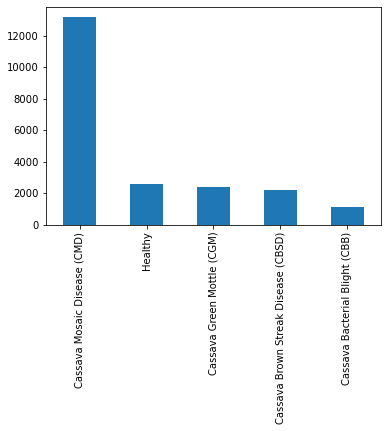

In [42]:
#get classes distribution #Note: classes very imbalanced (CMD has a lot more occurences than the rest of the classes)
df_train.disease.value_counts().plot(kind='bar')

In [5]:
#format labels on df and store them
df_train.label = df_train.label.astype('str')
labels = list(df_train.disease.unique())
labels

['Cassava Bacterial Blight (CBB)',
 'Cassava Mosaic Disease (CMD)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Healthy']

# ****Display Images from Each Class****

In [44]:
def fusing_boxes_id(dataframe, class_id):
    # filter on class_id
    dataframe.label = dataframe.label.astype(int)
    filtered_dataframe = dataframe.loc[dataframe.label == class_id,
                                       ['image_id','label']]
    
    return filtered_dataframe.groupby(['image_id']).mean()


def select_4_from_each(dataframe):
    
    "For each class, returns 4 indexes and image paths"
    
    # Initialize dictionaries
    class_id_index_examples, class_id_image_examples = {}, {}
    image_ids_train_dataframe = list(df_train.image_id)#.apply(lambda x: int(x.split('.')[0])))
   
    
    # Loop over different classes
    for class_id in range(5):
        fusing_boxes_dataframe = fusing_boxes_id(dataframe, class_id).sample(4)
        # image_id
        fusing_box_indexes = fusing_boxes_dataframe.index
        # Infer indexes
        class_id_index_examples[str(class_id)] = [image_ids_train_dataframe.index(fusing_box_indexes[cid]) for cid in range(4)]
        # Infer image paths
        class_id_image_examples[str(class_id)] = fusing_box_indexes
        
    return class_id_index_examples, class_id_image_examples

class_id_index_examples, class_id_image_examples = select_4_from_each(df_train)

In [45]:
def display_images(class_id, graph_indexes = np.arange(4)):
    
    # Get files
    files_index = class_id_index_examples[str(class_id)]
    files_list = class_id_image_examples[str(class_id)]
    
    # define subplot
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    for graph_index in graph_indexes:
        full_filename = files_list[graph_index]#+'.jpg'
        ds = os.path.join(base_path, 
                                  'train_images',
                                  full_filename)
#         ds = cv2.imread(ds)
#         plt.imshow(ds)
#         plt.show()

#         axs[graph_index%3, (graph_index)//3].set_title('Label: %s \n'%class_id,
#                   fontsize=18)
        axs[graph_index%2, (graph_index)//2].imshow(mpimg.imread(ds))
                  
                     
    # the bottom of the subplots of the figure
    plt.subplots_adjust(bottom = 0.001)
    plt.subplots_adjust(top = 0.99)
    
    # show the figure
    plt.show()

#  **Cassava Bacterial Blight (CBB) [class 0]**

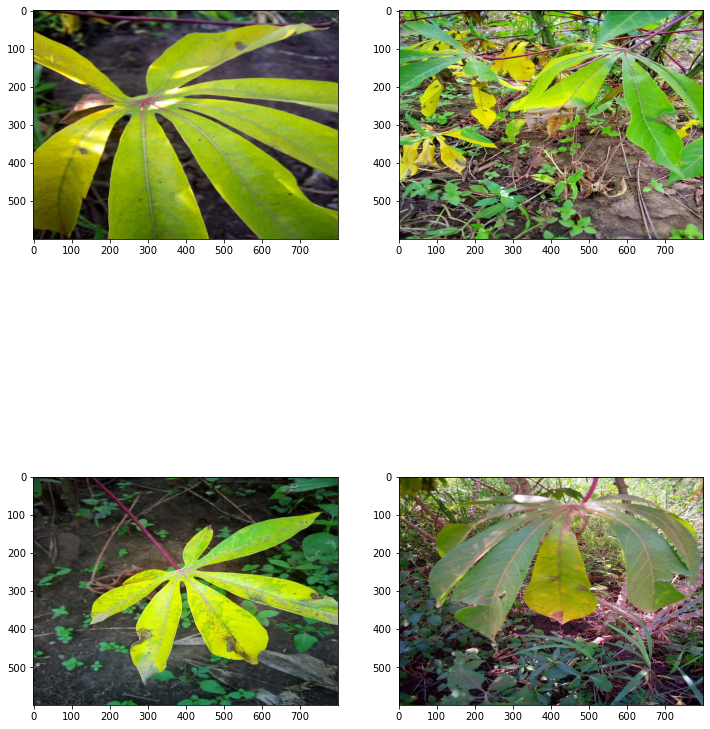

In [46]:
display_images('0')

# **Cassava Brown Streak Disease (CBSD) [class 1]**

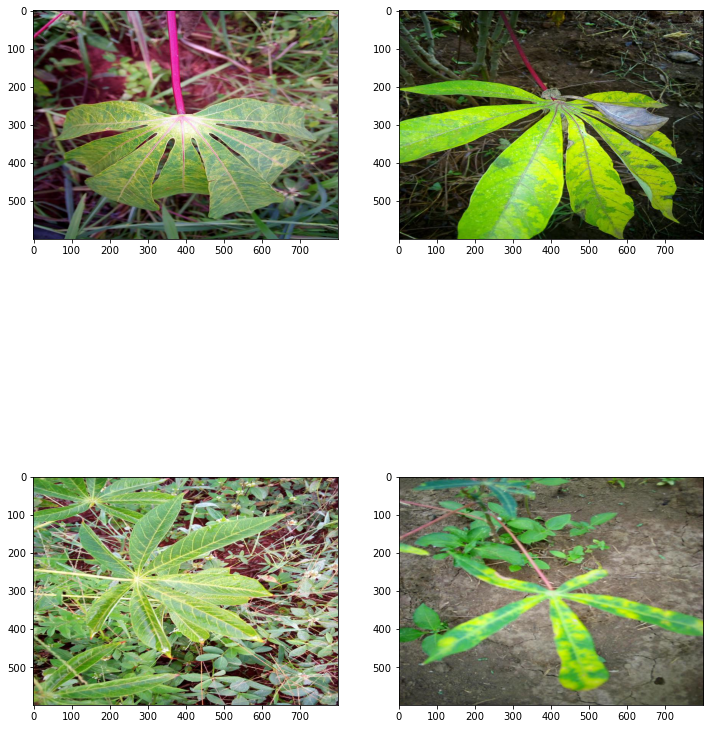

In [47]:
display_images('1')

# **Cassava Green Mottle (CGM) [class 2]**

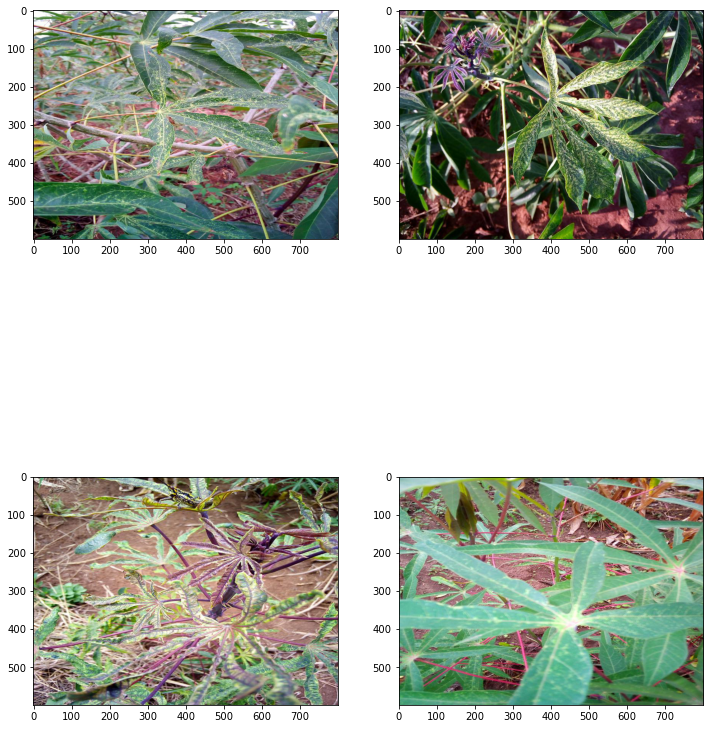

In [48]:
display_images('2')

# **Cassava Mosaic Disease (CMD) [class 3]**

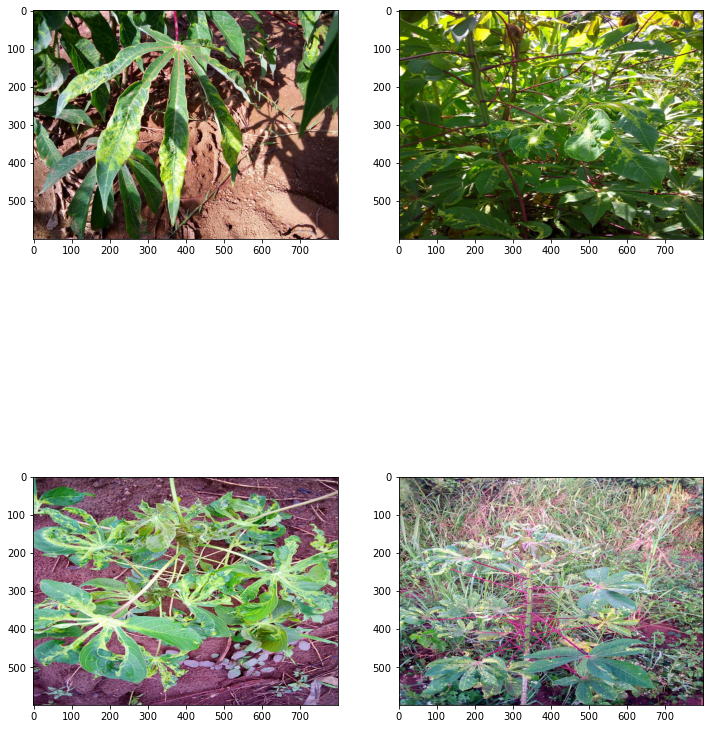

In [49]:
display_images('3')

# **Healthy [class 4]**

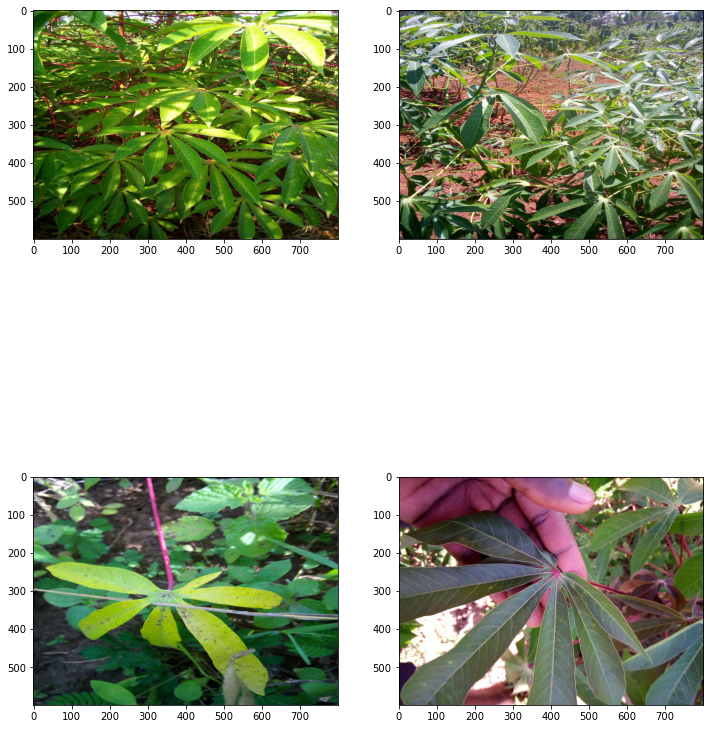

In [50]:
display_images('4')

# Modelling

In [6]:
#main params
num_epochs = 10
learning_rate = 1e-4
bs = 32
targetsize = 224

In [7]:
df_train.label = df_train.label.astype(str)

In [8]:
train_aug = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1/255.0,
    rotation_range = 20,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    horizontal_flip = True,
    fill_mode = 'nearest')

train_gen = train_aug.flow_from_dataframe(df_train,
                         directory = os.path.join(base_path, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (targetsize, targetsize),
                         batch_size = bs,
                         class_mode = "sparse")

val_aug = ImageDataGenerator(validation_split = 0.2, rescale = 1/255.0)

val_gen = val_aug.flow_from_dataframe(df_train,
                         directory = os.path.join(base_path, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (targetsize, targetsize),
                         batch_size = bs,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [12]:
#load ResNet-50 with the head FC layer off
base_models = {'VGG16' : VGG16(weights='imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3))),
              'VGG19' : VGG19(weights='imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3))),
              'Xception' : Xception(weights='imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3))),
              'EfficientB3' : EfficientNetB3(weights='imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3))),
               'ResNet50' : ResNet50(weights='imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3)))
              }


94773248/94765736 [==============================] - 1s 0us/step


In [55]:
#transfer learning
def create_model_tl(base_model):
        
    #construct the head of the model that will be placed on top of the base model
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7,7))(head_model)
    head_model = Flatten(name='flatten')(head_model)
    head_model = Dense(256, activation='relu')(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(len(labels), activation = 'softmax')(head_model)
    
    #place the head FC model on top of the basemodel
    model = Model(inputs = base_model.input, outputs = head_model)
    
    # loop over all layers in the base model and freeze them so they will
    # NOT be updated during the training process
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [9]:
def fit_model(model):
    
    
    #compile the model
    opt = Adam(lr=learning_rate, decay = learning_rate/num_epochs)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ['accuracy'])
    
    #add early stoppinng
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 3, verbose = True)
    
    #add checkpoints
    checkpoint = ModelCheckpoint(
        "CassavaLeafDisease_best_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
    )
    
    #train the model
    m = model.fit_generator(
    train_gen,
    steps_per_epoch = len(df_train)*0.8 // bs,
    validation_data = val_gen,
    validation_steps = len(df_train)*0.2 // bs,
    epochs = num_epochs,
    callbacks=[es, checkpoint])
    
    
    return m
    

In [57]:
fitted_models = {}
for name, base_model in base_models.items():
    model = create_model_tl(base_model)
    history = fit_model(model)
    
    fitted_models[name] = history

Epoch 1/10
534/534 [==============================] - 479s 897ms/step - loss: 1.1023 - accuracy: 0.6228 - val_loss: 0.9605 - val_accuracy: 0.6520
Epoch 2/10
534/534 [==============================] - 347s 650ms/step - loss: 0.9827 - accuracy: 0.6499 - val_loss: 0.9213 - val_accuracy: 0.6666
Epoch 3/10
534/534 [==============================] - 345s 646ms/step - loss: 0.9460 - accuracy: 0.6593 - val_loss: 0.8952 - val_accuracy: 0.6748
Epoch 4/10
534/534 [==============================] - 343s 642ms/step - loss: 0.9256 - accuracy: 0.6652 - val_loss: 0.8795 - val_accuracy: 0.6783
Epoch 5/10
534/534 [==============================] - 342s 640ms/step - loss: 0.9108 - accuracy: 0.6704 - val_loss: 0.8669 - val_accuracy: 0.6840
Epoch 6/10
534/534 [==============================] - 344s 644ms/step - loss: 0.8978 - accuracy: 0.6763 - val_loss: 0.8566 - val_accuracy: 0.6856
Epoch 7/10
534/534 [==============================] - 346s 647ms/step - loss: 0.8917 - accuracy: 0.6764 - val_loss: 0.8514 -

In [15]:
def plot_model_results(m, N, model_name):
    
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    fig.suptitle("Training Loss and Accuracy of " + model_name + " on Dataset", fontsize = 15)
    
    ax1.plot(np.arange(1, len(m.history["loss"]) + 1), m.history["loss"], label="train_loss")
    ax1.plot(np.arange(1, len(m.history["val_loss"]) + 1), m.history["val_loss"], label="val_loss")
    ax2.plot(np.arange(1, len(m.history["accuracy"]) + 1), m.history["accuracy"], label="train_acc")
    ax2.plot(np.arange(1, len(m.history["val_accuracy"]) + 1), m.history["val_accuracy"], label="val_acc")

    
    ax1.set_xlabel("Epoch #")
    ax2.set_xlabel("Epoch #")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    ax2.set_title('Accuracy', fontsize=15)
    ax1.set_title('Loss', fontsize=15)
    plt.show()

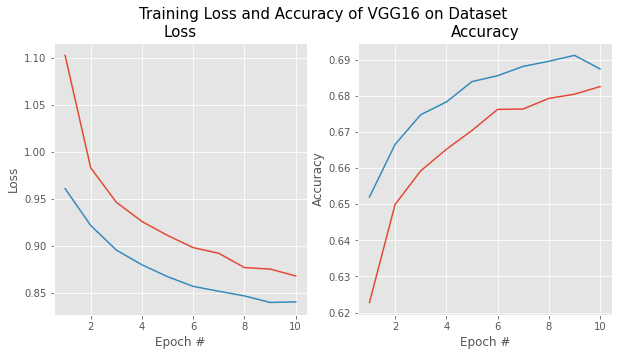

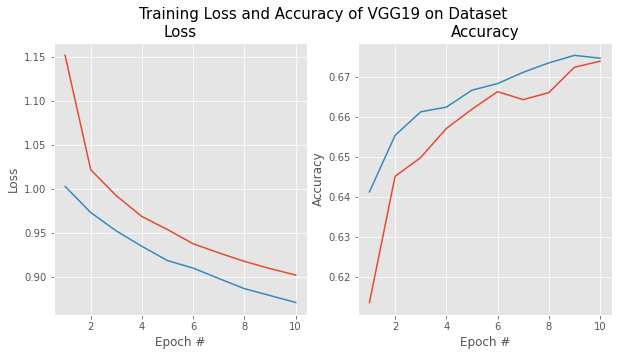

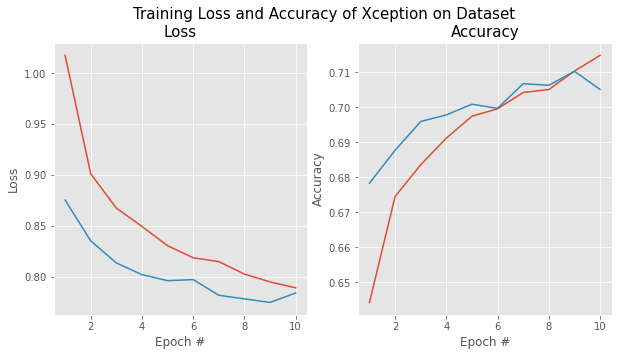

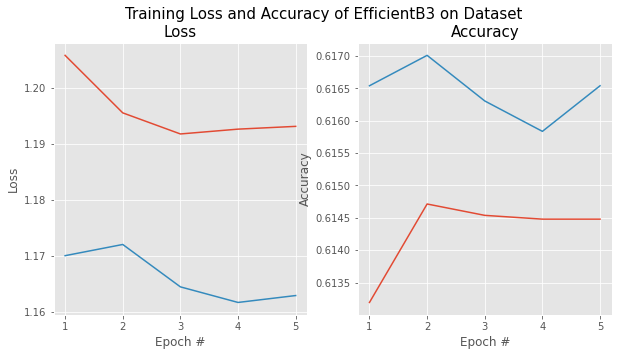

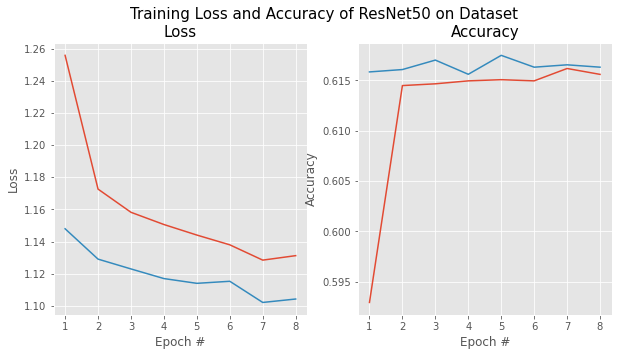

In [59]:
for name, base_model in fitted_models.items():
    plot_model_results(base_model, num_epochs, name)

In [60]:
#Xception seems to be performing best - train from scratch on 15 epochs
def create_model(base_model):
        
    #construct the head of the model that will be placed on top of the base model
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7,7))(head_model)
    head_model = Flatten(name='flatten')(head_model)
    head_model = Dense(256, activation='relu')(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(256, activation='relu')(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(len(labels), activation = 'softmax')(head_model)
    
    #place the head FC model on top of the basemodel
    model = Model(inputs = base_model.input, outputs = head_model)
    
    # loop over all layers in the base model and freeze them so they will
    # NOT be updated during the training process
    for layer in base_model.layers:
        layer.trainable = True
    
    return model

In [61]:
num_epochs = 15
model = create_model(base_models['Xception'])
history = fit_model(model)

Epoch 1/15
534/534 [==============================] - 413s 773ms/step - loss: 0.8661 - accuracy: 0.6727 - val_loss: 0.6615 - val_accuracy: 0.7519
Epoch 2/15
534/534 [==============================] - 410s 767ms/step - loss: 0.6163 - accuracy: 0.7857 - val_loss: 0.6495 - val_accuracy: 0.7606
Epoch 3/15
534/534 [==============================] - 409s 765ms/step - loss: 0.5135 - accuracy: 0.8241 - val_loss: 0.6218 - val_accuracy: 0.7815
Epoch 4/15
534/534 [==============================] - 411s 770ms/step - loss: 0.4389 - accuracy: 0.8491 - val_loss: 0.6010 - val_accuracy: 0.7944
Epoch 5/15
534/534 [==============================] - 408s 763ms/step - loss: 0.3765 - accuracy: 0.8721 - val_loss: 0.6068 - val_accuracy: 0.8008
Epoch 6/15
534/534 [==============================] - 408s 763ms/step - loss: 0.3255 - accuracy: 0.8897 - val_loss: 0.6986 - val_accuracy: 0.7996
Epoch 7/15
534/534 [==============================] - 408s 763ms/step - loss: 0.2759 - accuracy: 0.9088 - val_loss: 0.8113 -

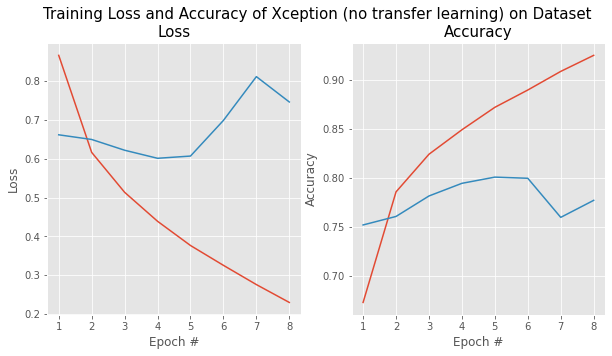

In [62]:
plot_model_results(history, num_epochs, 'Xception (no transfer learning)')

In [63]:
import pickle
with open('Xception_model_weights', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# history.save('xception_model.h5')

In [10]:
#model clearly overfitting - add regularization, reduce number of neurons and re-train
def create_reg_model(base_model):
        
    #construct the head of the model that will be placed on top of the base model
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7,7))(head_model)
    head_model = Flatten(name='flatten')(head_model)
    head_model = Dense(128, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
)(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(128, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
)(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(len(labels), activation = 'softmax')(head_model)
    
    #place the head FC model on top of the basemodel
    model = Model(inputs = base_model.input, outputs = head_model)
    
    # loop over all layers in the base model and freeze them so they will
    # NOT be updated during the training process
    for layer in base_model.layers:
        layer.trainable = True
    
    return model

In [13]:
num_epochs = 15
model = create_reg_model(base_models['Xception'])
history_reg = fit_model(model)

Epoch 1/15
534/534 [==============================] - 586s 1s/step - loss: 0.9134 - accuracy: 0.6566 - val_loss: 0.6450 - val_accuracy: 0.7643
Epoch 2/15
534/534 [==============================] - 506s 947ms/step - loss: 0.6502 - accuracy: 0.7764 - val_loss: 0.5510 - val_accuracy: 0.8015
Epoch 3/15
534/534 [==============================] - 508s 950ms/step - loss: 0.5477 - accuracy: 0.8144 - val_loss: 0.5846 - val_accuracy: 0.7914
Epoch 4/15
534/534 [==============================] - 505s 946ms/step - loss: 0.4798 - accuracy: 0.8380 - val_loss: 0.5750 - val_accuracy: 0.8015
Epoch 5/15
534/534 [==============================] - 504s 945ms/step - loss: 0.4165 - accuracy: 0.8605 - val_loss: 0.6062 - val_accuracy: 0.8066
Epoch 6/15
534/534 [==============================] - 508s 952ms/step - loss: 0.3641 - accuracy: 0.8784 - val_loss: 0.6324 - val_accuracy: 0.8050
Epoch 7/15
534/534 [==============================] - 507s 949ms/step - loss: 0.3057 - accuracy: 0.8961 - val_loss: 0.7189 - va

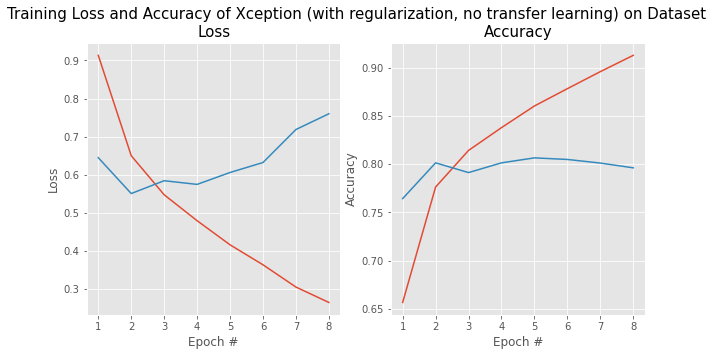

In [16]:
plot_model_results(history_reg, num_epochs, 'Xception (with regularization, no transfer learning)')
#model clearly still overfitting so two things to add on to do list:
#-augment minority classes
#-train a different model architecture

# Predict on test and Submit

In [17]:
test_path = "../input/cassava-leaf-disease-classification/test_images/"
test_imgs = os.listdir(test_path)

preds = []
for test_img in test_imgs:
    img = image.load_img(test_path + test_img, target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img).argmax(axis=1)
    preds.append(result)
print(preds)

[array([1])]


In [18]:
final_df = pd.DataFrame({'image_id': test_imgs, 'label': preds})
final_df.to_csv('submission.csv', index = False)